In [46]:
from  google.colab import drive  
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/algo trading/stocks
### save and load data using pickle
import pickle
def psave(dataframe, fname):
    with open('{}.pkl'.format(fname),'wb') as pickle_file:
        pickle.dump(dataframe,pickle_file)
        
def pload(fname):
  
  with open('{}.pkl'.format(fname),'rb') as pickle_file:
      dataframe=pickle.load(pickle_file)
      return dataframe

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/algo trading/stocks


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sys

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from itertools import product
from keras.layers import Input
from keras.layers import LSTM
import h5py

In [29]:
sys.path.append("/content/drive/MyDrive/Colab Notebooks/classes")
%reload_ext autoreload
%autoreload 2

In [30]:



from PropertyTest_DataGeneration import Test as t
from PropertyTest_DataGeneration import Gen as g
from ou_process import OUP

In [31]:
train_s=np.datetime64('2013-12-30')
train_e=np.datetime64('2017-12-29')

vali_s=np.datetime64('2018-01-02')
vali_e=np.datetime64('2018-12-31')

test_s=np.datetime64('2019-01-02')
test_e=np.datetime64('2019-12-30')


df=pload('selectedpairs')

In [32]:
len(df)

20

In [33]:

def LSTMM(x_train,y_train,x_test,y_test,step,lstm1,lstm2,epoch,earlystop=True):

  model = Sequential()
  model.add(LSTM(lstm1, activation='relu', return_sequences=True, input_shape=(step, 1)))
  model.add(LSTM(lstm2, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  if earlystop==True:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=int(epoch*0.4),verbose=0)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)

    model.fit(x_train, y_train,
            epochs=epoch,
        callbacks=[callback,mc],verbose=0)
    model = load_model('best_model.h5')
  else:
    model.fit(x_train, y_train, epochs=epoch, verbose=0)
  
  score=model.evaluate(x_test,y_test,batch_size=1)

  return score,model



In [23]:
sp=df['spread'].iloc[0]
vali_index=sp.loc[vali_s:vali_e].index
test_index=sp.loc[test_s:test_e].index

In [25]:
lstm_n=np.array([8,16,32,64,128])
epochs=[50,100,150,200,250]

#len(df.index)
result={'LSTM_test':[],'LSTM_vali':[],'LSTM_mse':[],'LSTM_para':[]}

for i in range(len(df)):
  
  sp=df['spread'].iloc[i]
  step=int(df['T'].iloc[i])
 
  x,y=g.Lag_Feature_Target(sp.loc[train_s:test_e],step)
 
  train_length_temp=len(sp.loc[train_s:train_e])
  vali_length=len(sp.loc[vali_s:vali_e])
  test_length=len(sp.loc[test_s:test_e])
  train_length=train_length_temp-step
  train_split=train_length
  va_split=vali_length+train_length
  test_split=vali_length+train_length+test_length
  x_train,y_train=x[:train_split],y[:train_split]
  x_vali,y_vali=x[train_split:va_split],y[train_split:va_split]
  x_test,y_test=x[va_split:test_split],y[va_split:test_split]

  place=np.searchsorted(lstm_n,step , side='left')

  lstms1=lstm_n[place-1:place+1].tolist()
  mse_min=999999.9
  best_para=(-1,-1,-1,-1)
  best_model=Model()
  for lstm1 in lstms1:
    lstms2=[lstm1,int(lstm1/2)]
    for lstm2 in lstms2:


      
      for epoch in epochs:
        print((lstm1,lstm2,epoch))
        score,model=LSTMM(x_train,y_train,x_vali,y_vali,step,lstm1,lstm2,epoch,earlystop=False)


        if score<mse_min:
          mse_min=score
          best_model=model
          best_para=(lstm1,lstm2,epoch)

        




  ytest = best_model.predict(x_test,batch_size=1, verbose=1)
  yvali = best_model.predict(x_vali,batch_size=1, verbose=1)
  yvali=pd.Series(yvali.reshape(len(vali_index)),index=vali_index)
  ytest=pd.Series(ytest.reshape(len(test_index)),index=test_index)
  result['LSTM_test'].append(ytest)
  result['LSTM_vali'].append(yvali)
  result['LSTM_mse'].append(mse_min)
  result['LSTM_para'].append(best_para)



        
  
        
  print(i,'done.')
  
  psave(result,'LSTMMM{}'.format(i))


            

  

(32, 32, 50)
251/251 [==============================] - 1s 4ms/step - loss: 0.1498
(32, 32, 100)
251/251 [==============================] - 1s 4ms/step - loss: 0.1298
(32, 32, 150)
251/251 [==============================] - 1s 4ms/step - loss: 0.1207
(32, 32, 200)
251/251 [==============================] - 1s 4ms/step - loss: 0.3351
(32, 32, 250)
251/251 [==============================] - 1s 4ms/step - loss: 0.0743
(32, 16, 50)
251/251 [==============================] - 1s 4ms/step - loss: 0.1444
(32, 16, 100)
251/251 [==============================] - 1s 4ms/step - loss: 0.0692
(32, 16, 150)
251/251 [==============================] - 1s 4ms/step - loss: 0.1210
(32, 16, 200)
251/251 [==============================] - 1s 4ms/step - loss: 0.0832
(32, 16, 250)
251/251 [==============================] - 1s 4ms/step - loss: 0.1237
(64, 64, 50)
251/251 [==============================] - 1s 4ms/step - loss: 0.0956
(64, 64, 100)
251/251 [==============================] - 1s 4ms/step - loss: 0.

In [58]:
df2=pload('selectedpairs_para')

In [42]:

for i in range(20):
  for key in ['LSTM_vali','LSTM_test','LSTM_mse','LSTM_para']:
    df2.iloc[j[i]][key]=result[key][i]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


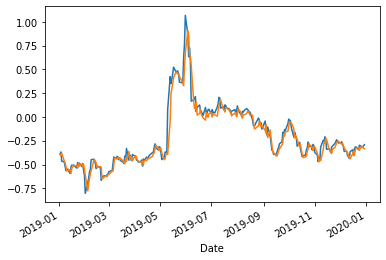

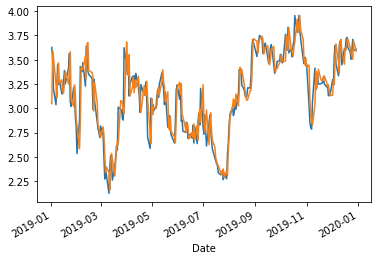

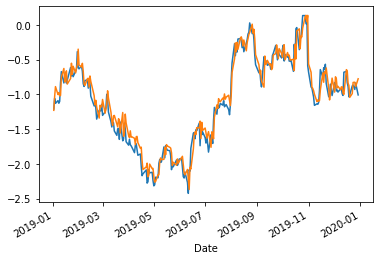

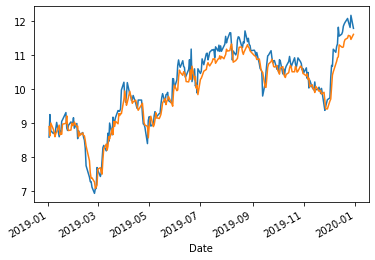

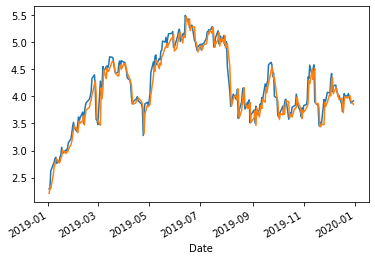

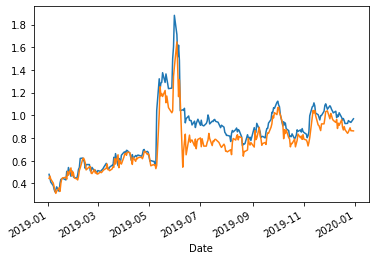

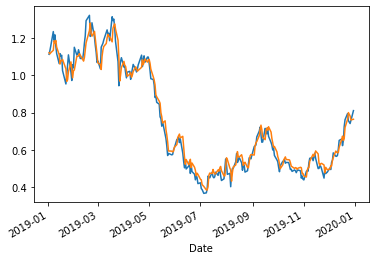

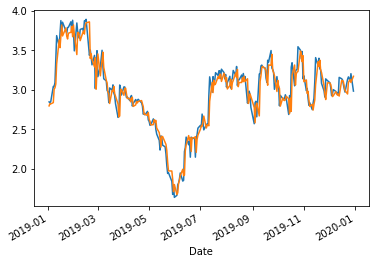

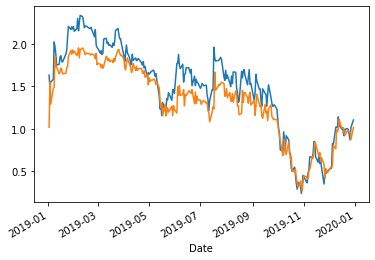

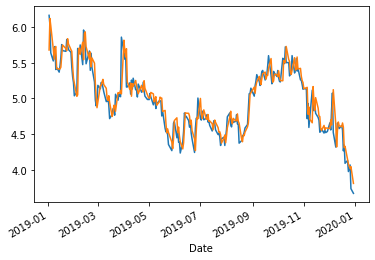

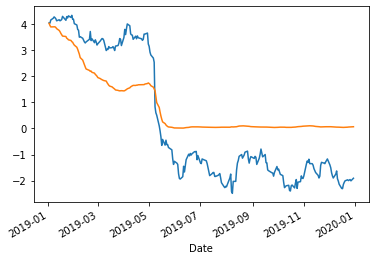

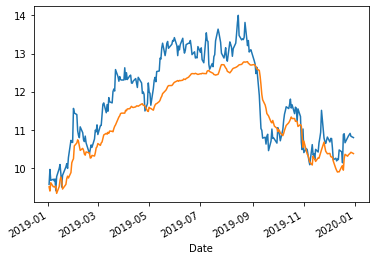

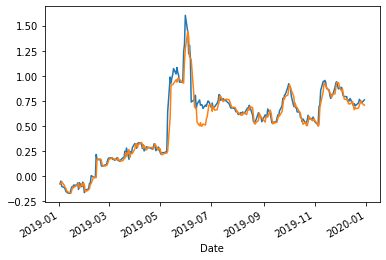

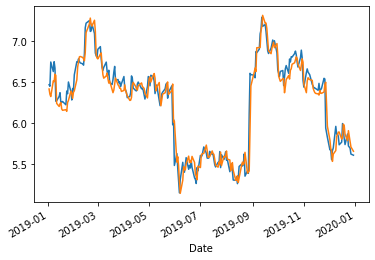

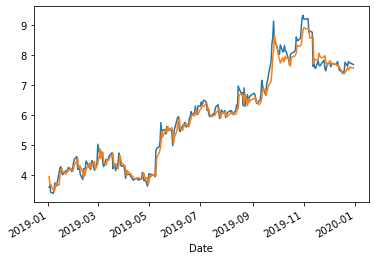

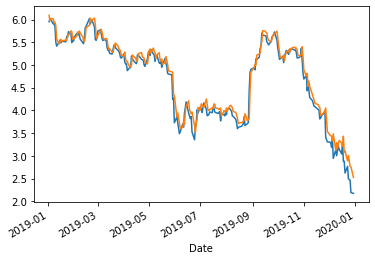

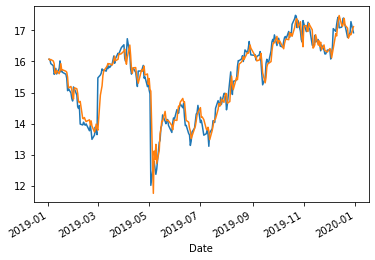

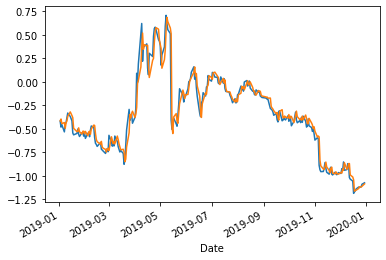

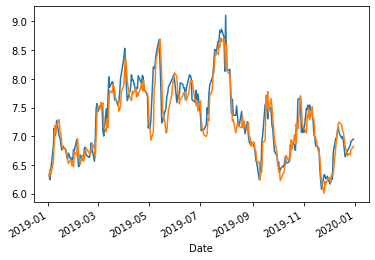

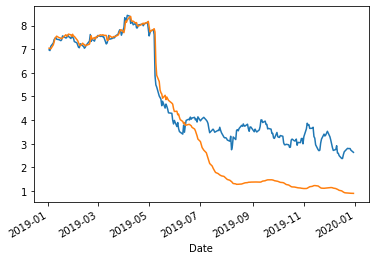

In [45]:
for i in range(20):
  plt.figure(i)
  df2.iloc[i]['spread'].loc[test_s:test_e].plot()
  df2.iloc[i]['LSTM_test'].plot()

In [65]:
df2

,cross,mean1,pair,beta,spread,ret,mean2,cross2,mean3,cross3,meandiff,T,corr,LSTM_vali,LSTM_test,LSTM_mse,LSTM_para,para,vali_return,vali_record,LSTM_ret
363082,37,-33.884243,"[CTHR, HAYN]",0.050000,Date 2013-12-02 2.929801 2013-12-03 2.79...,Date 2013-12-02 -0.044655 2013-12-03 -0.01...,-0.242134,40,-0.571331,18,0.329197,51.0,0.646790,Date 2018-01-02 -0.135967 2018-01-03 -0.21...,Date 2019-01-02 -0.386866 2019-01-03 -0.40...,0.002326,"(64, 32, 150)",(),0.000000,[],0.000000
99348,33,-17.050050,"[AVNW, MMYT]",0.146939,Date 2013-12-02 11.808979 2013-12-03 11....,Date 2013-12-02 -0.025819 2013-12-03 -0.03...,3.632221,49,3.595694,26,0.036528,42.0,0.506716,Date 2018-01-02 3.195875 2018-01-03 3.00...,Date 2019-01-02 3.048844 2019-01-03 3.59...,0.056004,"(64, 64, 50)","(0.35, 0.05, 0.7, 0.85)",87.561959,"[NAN, Long, Clear, Long, Clear, Long, Clear, L...",0.000000
288449,36,-27.130426,"[VOXX, NTCT]",0.224490,Date 2013-12-02 10.296735 2013-12-03 10....,Date 2013-12-02 0.029433 2013-12-03 -0.01...,-0.577103,57,-0.680304,28,0.103202,36.0,0.610608,Date 2018-01-02 -1.189168 2018-01-03 -1.42...,Date 2019-01-02 -1.229590 2019-01-03 -1.03...,0.038287,"(64, 64, 200)",(),0.000000,[],0.000000
216234,35,-2.241410,"[TCBIL, VLGEA]",0.534694,Date 2013-12-02 1.446036 2013-12-03 1....,Date 2013-12-02 -0.154412 2013-12-03 1.13...,8.002588,53,8.540720,14,-0.538132,39.0,0.465233,Date 2018-01-02 9.703416 2018-01-03 9.63...,Date 2019-01-02 8.892055 2019-01-03 8....,0.062033,"(32, 32, 50)","(0.35, 0.05, 0.65, 1)",3.588377,"[NAN, Short, Clear, Short, Clear, Short, Clear...",-0.008139
314459,91,3.059907,"[FDUS, MGIC]",0.961224,Date 2013-12-02 4.596692 2013-12-03 4.48...,Date 2013-12-02 -0.023360 2013-12-03 0.00...,3.302077,91,2.671474,25,0.630603,23.0,0.871486,Date 2018-01-02 3.160225 2018-01-03 3.15...,Date 2019-01-02 2.210867 2019-01-03 2.30...,0.024078,"(16, 8, 150)","(0.35, 0, 0.65, 1)",4.589588,"[NAN, Short, Clear, Long, Clear, Short, Clear,...",0.000000
363238,32,-6.491330,"[CTHR, CCLP]",0.185714,Date 2013-12-02 3.362121 2013-12-03 3.20...,Date 2013-12-02 -0.045473 2013-12-03 -0.00...,0.039106,34,0.189550,34,-0.150444,60.0,0.657552,Date 2018-01-02 0.489809 2018-01-03 0.38...,Date 2019-01-02 0.444297 2019-01-03 0.46...,0.002509,"(32, 16, 150)","(0.35, 0, 0.65, 0.95)",27.659026,"[NAN, Short, Clear, Long, Clear, Long, Clear, ...",-0.016352
365248,38,-5.172277,"[TGA, CCLP]",0.282653,Date 2013-12-02 4.670289 2013-12-03 4.67...,Date 2013-12-02 0.001556 2013-12-03 0.06...,0.580727,39,0.724924,11,-0.144197,52.0,0.880470,Date 2018-01-02 0.140445 2018-01-03 0.11...,Date 2019-01-02 1.120790 2019-01-03 1.11...,0.013987,"(64, 64, 50)","(0.35, 0, 0.65, 1)",8.930240,"[NAN, Short, Clear, Short, Clear, Short, Clear...",0.000000
288537,40,2.226178,"[VOXX, MARPS]",0.844898,Date 2013-12-02 9.853340 2013-12-03 10....,Date 2013-12-02 0.015442 2013-12-03 -0.00...,2.983573,48,3.017976,43,-0.034403,43.0,0.777196,Date 2018-01-02 3.501773 2018-01-03 3.47...,Date 2019-01-02 2.797970 2019-01-03 2.82...,0.027611,"(64, 64, 150)","(0.35, 0, 0.9, 1)",89.489938,"[NAN, Short, Clear, Short, Clear, Short, Clear...",0.000000
439897,34,-1.855255,"[MIND, CCLP]",0.728571,Date 2013-12-02 9.905243 2013-12-03 9.67...,Date 2013-12-02 -0.023199 2013-12-03 -0.03...,0.321557,35,0.012027,15,0.309530,58.0,0.784027,Date 2018-01-02 0.007168 2018-01-03 0.02...,Date 2019-01-02 1.018617 2019-01-03 1.55...,0.027732,"(32, 16, 50)","(0.35, 0, 0.65, 0.8)",1.409449,"[NAN, Short, Clear, Short, Clear, Short, Clear...",1.276968
99073,34,-10.444400,"[AVNW, EPZM]",0.146939,Date 2013-12-02 11.102204 2013-12-03 10....,Date 2013-12-02 -0.028125 2013-12-03 -0.05...,4.602847,44,6.254098,32,-1.651251,46.0,0.696870,Date 2018-01-02 5.712224 2018-01-03 5.71...,Date 2019-01-02 5.678904 2019-01-03 6.12...,0.043209,"(32, 16, 50)","(0.35, 0.05, 0.8, 1)",1371.746005,"[NAN, Long, Clear, Long, Clear, Long, Clear, S...",0.000000


In [66]:
psave(df2,'selectedpairs_LSTM')